In [1]:
#A data based approach using Stack Overflow’s developer survey data from 2018.
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import scikitplot as skplt


D:\DataScientist\Anaconda\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Read the survey_results_schema.csv -- Questions of the survey conducted by Stack Overflow in 2018
schema = pd.read_csv('D:\\DataScientist\\NanoDegree\\Proj1\\survey_results_schema.csv')
schema.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [3]:
#Read the survey_results_public.csv -- answers to the survey conducted by Stack Overflow in 2018
df_full = pd.read_csv('D:\\DataScientist\\NanoDegree\\Proj1\\survey_results_public.csv')
df_full.shape


D:\DataScientist\Anaconda\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(98855, 129)

In [4]:
#Function to remove the NaN values from the dataset by dropping the rows with NaNs
def remove_NaNs(df,col):
    '''
    INPUT
    df - pandas dataframe 
    col - list of the column/s to search for NaNs
    
    OUTPUT
    DataFrame with NA entries dropped from it.
    '''
    return df.dropna(subset=col,axis=0)

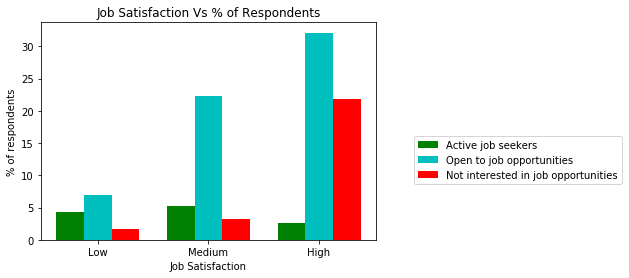

In [5]:
#First let's see the Effect of Job Satisfaction, 
#i.e. are the respondents happy with their current job or are they looking for a switch.

#Encode JobSatisfaction - make 3 wider buckets instead of 7 finer
df_full['JobSatisfactionCode'] = df_full.JobSatisfaction.apply(lambda x:{'Extremely satisfied':2,
                                                                         'Moderately satisfied':2,
                                                                         'Slightly satisfied':1,
                                                                         'Neither satisfied nor dissatisfied':1,
                                                                         'Slightly dissatisfied':1,
                                                                         'Moderately dissatisfied':0,
                                                                         'Extremely dissatisfied':0                      
                                                                        }.get(x,x))

#Remove all the rows with NaNs in the columns
df = remove_NaNs(df_full,['JobSearchStatus','JobSatisfactionCode'])

#Select respondents who are not students and are employeed as this is related to Job Satisfaction
df = df[df['Student'] == 'No']
df = df[df['Employment'].str.contains('Not employed') == False]

df_plot = ((df[['JobSearchStatus','JobSatisfactionCode']]).groupby(['JobSearchStatus','JobSatisfactionCode']).size()/len(df)*100)

#Plot 3 line graphs, 1 for each JobSearchStatus
df_plot_1 = df_plot[df_plot.index.get_level_values(0) == 'I am actively looking for a job']
df_plot_2 = df_plot[df_plot.index.get_level_values(0) == "I’m not actively looking, but I am open to new opportunities"]
df_plot_3 = df_plot[df_plot.index.get_level_values(0) == 'I am not interested in new job opportunities']

ax = plt.subplot(111)

#Plot the JobSatisfactionCode Vs MeanSalary for each JobSearchStatus
ax.bar(df_plot_1.index.get_level_values(1)+0,df_plot_1,width=0.25,color='g',label='Active job seekers')
ax.bar(df_plot_2.index.get_level_values(1)+0.25,df_plot_2,width=0.25,color='c',label='Open to job opportunities')
ax.bar(df_plot_3.index.get_level_values(1)+0.5,df_plot_3,width=0.25,color='r',label='Not interested in job opportunities')

plt.xlabel('Job Satisfaction', fontsize=10)
plt.ylabel('% of respondents', fontsize=10)
plt.title('Job Satisfaction Vs % of Respondents')
ax.legend(bbox_to_anchor=(1.75, 0.5))
plt.xticks(np.arange(0,3,1)+0.25)
ax.set_xticklabels(['Low','Medium','High'])
#ax.yaxis.grid() # horizontal lines
plt.show()

Inference:
- People who are active job seekers have the least job satisfaction, followed by people who are open to opportunities
- People who are most satisfied with their jobs are not interested in new job opportunities

There is a set of 11 questions that I considered for further analysis. These are related to assessing a job's benefits package. Respondents ranked the following aspects of a job's benefits package from most to least important, where 1 is most important and 11 is least important.
1. Salary and/or bonuses
2. Stock options or shares
3. Health insurance
4. Parental leave
5. Fitness or wellness benefit 
6. Retirement or pension savings matching
7. Company-provided meals or snacks
8. Computer/office equipment allowance
9. Childcare benefit
10. Transportation benefit 
11. Conference or education budget

In [6]:
#Remove NaNs from AssessBenefits question set
df = remove_NaNs(df_full,['AssessBenefits1'])

#Create a new dataframe with columns to hold the percentage of importance of Benefits assessed by the resopondents
df_benefits = pd.DataFrame()

#To get the full Question Text from schema 
pd.set_option('display.max_colwidth', -1)

#For the 11 Questions, find the importance of Benefits rated by the respondents 
#Each Question will have rating from 1 to 11, 1 being most important
for benefit_id in range(1,12):
    #Create the Column name by appending Question # to 'AssessBenefits'
    col = 'AssessBenefits'+str(benefit_id)
    
    #Get the corresponding Benefit Name from the schema
    benefit = (schema[schema['Column'] == col]['QuestionText']).to_string()
    
    #Manipulations required to get the Benefit name
    benefit = (benefit[benefit.find('important.')+11:])
    if ('(' in benefit):
        benefit = (benefit[:benefit.find('(')])
    #print(benefit)
    
    #Find the number of respondents for each rating for the Benefit - say Salary and Bonuses
    '''e.g. AssessBenefits1
        1.0     45588
        2.0     7361 
        3.0     3758 
        4.0     2390 
        5.0     1638 
        6.0     1215 
        7.0     854  
        8.0     666  
        9.0     523  
        10.0    495  
        11.0    430
        '''
    count_per_rating = (df[col]).groupby(df[col]).count()
    #print(count_per_rating)

    #Find the importance of that benefit - that is the rating with maximum number of respondents, 1.0 in the above example
    imp = int((count_per_rating/len(df)).idxmax())

    # % of respondents selecting that importance 
    perc = count_per_rating.max()/len(df)*100
    
    #Add the above information in the df_benefits dataframe
    df_benefits = df_benefits.append({'cols': benefit+':'+str(imp),
                                      'benefit':benefit,
                                      'perc': perc,
                                      'imp': imp},ignore_index=True)
    

#Sort the dataframe 
df_benefits.sort_values(by=['imp','perc'],ascending=[True, False],inplace=True)

#Revert the display setting
pd.set_option('display.max_colwidth', 55)


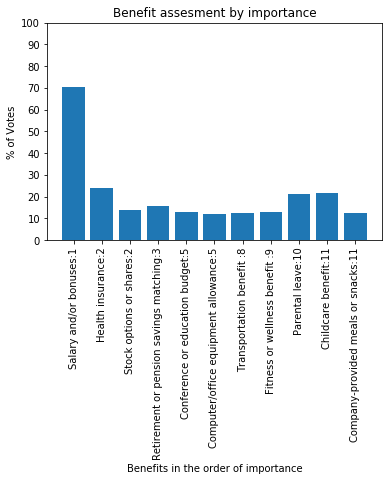

In [7]:
#Plot the bar chart for Benefits assessment by importance
index = np.arange(0,110,10)
plt.bar(df_benefits.cols,df_benefits.perc)
plt.xlabel('Benefits in the order of importance', fontsize=10)
plt.ylabel('% of Votes', fontsize=10)
plt.xticks(df_benefits.cols, fontsize=10, rotation=90)
plt.yticks(index,fontsize=10)
plt.title('Benefit assesment by importance')
plt.show()

The above chart indicates that 70% of repondents have selected 'Salary and/or Bouneses' as the most important benefit followed by 'Health Insurance' (~25%) and 'Stock options or shares' (~13%) as number 2. 

I will consider 'Salary and/or bonuses' benefit for further analysis. Let's see if there is any relationship between Salary, JobSatisfaction and JobSearchStatus.

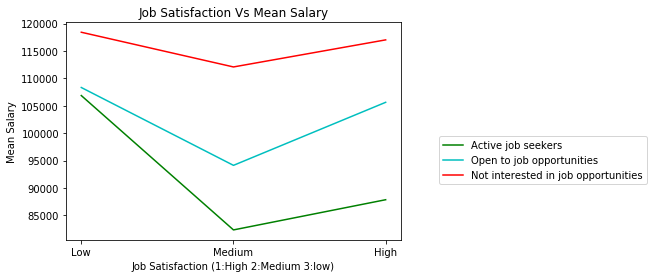

In [8]:
#Remove all the rows with NaNs in the 3 columns
df = df_full.dropna(subset=['JobSearchStatus','ConvertedSalary','JobSatisfactionCode',],how='any',axis=0)

#Select respondents who are not students and are employeed as this is related to Job Satisfaction
df = df[df['Student'] == 'No']
df = df[df['Employment'].str.contains('Not employed') == False]

df_plot = ((df[['JobSearchStatus','JobSatisfactionCode','ConvertedSalary']]).groupby(['JobSearchStatus','JobSatisfactionCode']).mean().sort_values(by=['JobSearchStatus','JobSatisfactionCode'],ascending=False))

#Plot 3 line graphs, 1 for each JobSearchStatus
df_plot_1 = df_plot[df_plot.index.get_level_values(0) == 'I am actively looking for a job']
df_plot_2 = df_plot[df_plot.index.get_level_values(0) == "I’m not actively looking, but I am open to new opportunities"]
df_plot_3 = df_plot[df_plot.index.get_level_values(0) == 'I am not interested in new job opportunities']
ax = plt.subplot(111)

#Plot the JobSatisfactionCode Vs MeanSalary for each JobSearchStatus
ax.plot(df_plot_1.index.get_level_values(1),df_plot_1.ConvertedSalary,'g',label='Active job seekers')
ax.plot(df_plot_2.index.get_level_values(1),df_plot_2.ConvertedSalary,'c',label='Open to job opportunities')
ax.plot(df_plot_3.index.get_level_values(1),df_plot_3.ConvertedSalary,'r',label='Not interested in job opportunities')
plt.xlabel('Job Satisfaction (1:High 2:Medium 3:low)', fontsize=10)
plt.ylabel('Mean Salary', fontsize=10)
#plt.xticks((np.arange(1,4)))
plt.xticks(np.arange(0,3,1))
ax.set_xticklabels(['Low','Medium','High'])

plt.title('Job Satisfaction Vs Mean Salary')
ax.legend(bbox_to_anchor=(1.75, 0.5))
#ax.grid()
plt.show()

#### Inferences from 'Job Satisfaction Vs Mean Salary' plot 
- People who are 'Active job seekers' have below average salaries. These are the people who are looking for a better paying jobs.
- Overall the job satisfaction is seen to go down (High to Medium) as the mean salary goes down upto a certain extent. After that even higher mean salary is not the factor in boosting the job satisfaction in all 3 groups.


D:\DataScientist\Anaconda\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


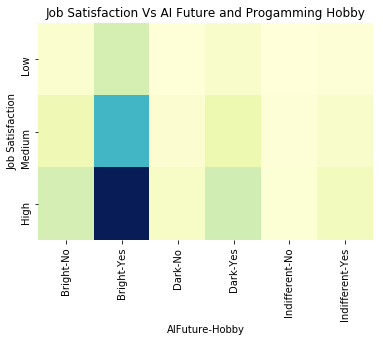

In [9]:
#Let's see if there is any relation between Coding being an Hobby/profession to Job Satisfaction
#Remove all the rows with NaNs in the 4 columns
df = remove_NaNs(df_full,['JobSatisfactionCode','Hobby','AIFuture'])
df = df[df['Student'] == 'No']


df['AIFuture'] = df_full.AIFuture.apply(lambda x:{"I'm excited about the possibilities more than worried about the dangers.":"Bright",
                                                    "I don't care about it, or I haven't thought about it.":"Indifferent",
                                                    "I'm worried about the dangers more than I'm excited about the possibilities.":"Dark",
                                                 }.get(x,x))

sns.heatmap(pd.crosstab([df.JobSatisfactionCode], [df.AIFuture,df.Hobby],rownames=['Job Satisfaction']),
            cmap="YlGnBu", annot=False, cbar=False)

ax5 = plt.subplot(111)

plt.xticks(rotation=90)
ax5.set_yticks(np.arange(0,3,1)+0.5)
ax5.set_yticklabels(['Low','Medium','High'])

plt.title('Job Satisfaction Vs AI Future and Progamming Hobby')
#ax.legend(bbox_to_anchor=(1.75, 0.5))
#ax.yaxis.grid() # horizontal lines
plt.show()

Inference
- People who love programming and also believe that future of AI is bright, tend to be most satisfied with their jobs as they are the people who are well equipped to embrace Change
- These are the people who love Challenges and do not much bogged down with the fear of Job Security

To conclude the project let's use various classifiers and find out which works best for out dataset.

In [10]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    print(df.shape)
    print('1. Drop all the rows with no JobSatisfactionCode')
    df.dropna(subset=['JobSatisfactionCode'],axis=0,inplace=True)

    
    print('2. Create X with all the columns except JobSatisfactionCode')
    X = df.drop('JobSatisfactionCode',axis=1)
    print(X.shape)
    
    print('3. Create y as encoded JobSatisfactionCode')
    y = df.JobSatisfactionCode
    
    print('4. Drop the Respondent columns from X')
    X = X.drop(['Respondent'],axis=1)
    print(X.shape)

    print('5. For each numeric variable in X, fill the column with the mean value of the column.')
    num_var_all = X.select_dtypes(include=['float','int']).columns
    num_vars_to_keep = ['AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5',
       'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10',
       'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3',
       'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6',
       'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9',
       'AssessBenefits10', 'AssessBenefits11','ConvertedSalary']
    # fill mode in the num_var_to_keep and mean in ConvertedSalary, remove remaining unwanted numeric columns
    for var in num_var_all:
        if(var in num_vars_to_keep):
            X[var] = X[var].mode()[0]
        elif(var == 'ConvertedSalary'):
            X['ConvertedSalary'].fillna(X['ConvertedSalary'].mean(),inplace=True)
        else:
            X = X.drop(var,axis=1,errors='ignore')
            
    #remove unwanted categorical columns
    X = X.drop(df.filter(regex='StackOverflow|HypotheticalTools|Ad|HopeFiveYears').columns,axis=1,errors='ignore')
    
    print('6. Create dummy columns for all the categorical variables in X, drop the original columns')
    cat_var_all = X.select_dtypes(include=['object']).columns
    
    
    cat_var_to_encode = ['Hobby', 'OpenSource', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 
       'YearsCoding', 'YearsCodingProf',
       'CareerSatisfaction', 'LastNewJob', 'UpdateCV', 
       'AgreeDisagree1', 'AgreeDisagree2', 'AgreeDisagree3', 'AIDangerous',
       'AIInteresting', 'AIResponsible', 'AIFuture', 'EthicsChoice',
       'WakeTime', 'HoursComputer', 'HoursOutside', 'SkipMeals', 
       'Exercise', 'Age', 'Dependents','JobSearchStatus']

    # hot-encode cat_var_to_encode, remove remaining unwanted categorical columns
    for var in cat_var_all:
        if(var in cat_var_to_encode):
            X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        else:
            X = X.drop(var,axis=1,errors='ignore')

     
    return X, y

In [11]:
#Use the function to create X and y
X, y = clean_data(df_full) 

(98855, 130)
1. Drop all the rows with no JobSatisfactionCode
2. Create X with all the columns except JobSatisfactionCode
(69276, 129)
3. Create y as encoded JobSatisfactionCode
4. Drop the Respondent columns from X
(69276, 128)
5. For each numeric variable in X, fill the column with the mean value of the column.
6. Create dummy columns for all the categorical variables in X, drop the original columns


In [15]:
# Normalize grades to values between 0 and 1 for more efficient computation
normalized_range = MinMaxScaler(feature_range=(-1,1))

X = normalized_range.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

0.6467305008901506


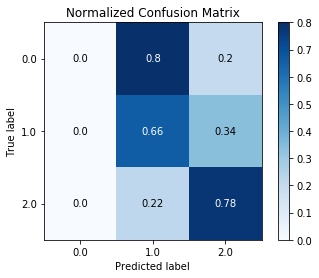

In [17]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train) 
y_pred = model.predict(X_test) 
  
# model accuracy for X_test   
accuracy = model.score(X_test, y_test) 
print(accuracy)

# plotting a confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

0.5637780878602704


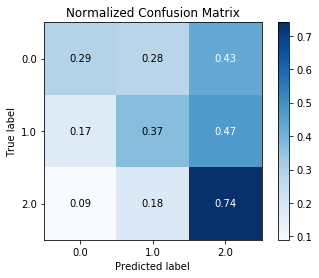

In [18]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train) 
y_pred = knn.predict(X_test)  

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy)

# plotting a confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

-1001809.0151822427


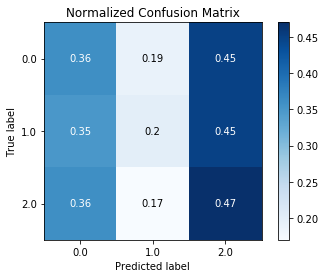

In [22]:
#KMeans Clustering

model = cluster.KMeans(n_clusters=3, n_init=200)
model.fit(X)
y_pred = model.labels_

# model accuracy for X_test   
accuracy = model.score(X_test, y_test) 
print(accuracy)

# plotting a confusion matrix 
skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True)
plt.show()

0.6098734542655054


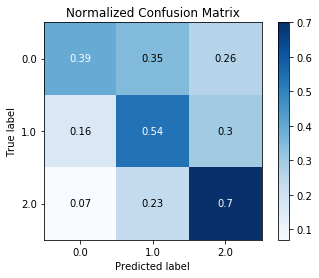

In [21]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
y_pred = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy) 
  
# plotting a confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

0.6875811961699466


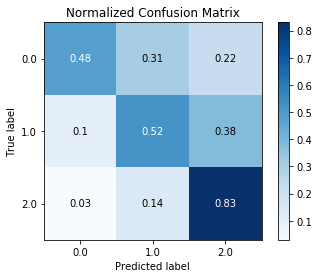

In [19]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
model = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
y_pred = model.predict(X_test) 
  
# model accuracy for X_test   
accuracy = model.score(X_test, y_test) 
print(accuracy)
  
# plotting a confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Support Vector Machine (SVM) works best on our dataset with the amount of missing data and with the current settings. 
0.69 accuracy score is not good but a better score could be achieved with some more tuning and experimentation.
Due to lack of computational power, unfortunately I have to stop here.